# Preamble

In [1]:
import sys
#sys.path.insert(0, dir_notebook)

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *

In [2]:
dir_home = '/mnt/home/kvantilburg/'
dir_ceph = dir_home+'ceph/luminous-basin/'
dir_source = dir_ceph+'data/products_80610202001_orbit1_chu12_spatialARF/'
dir_events = dir_source+'event_lists/'
dir_production = dir_ceph+'data/production/'
dir_res = dir_ceph+'results/data/'
dir_fig = '../figures/'

list_m = np.arange(3,40,0.1)

In [3]:
m_min = 5.1
m_max = 38.99
m_step = 0.1

# Load Results

## Yellin and Poisson

### Collect and process Poisson results

uncomment if you want to save/overwrite poisson results

### Load processed Poisson results

In [4]:
file_poisson = dir_res+'results_poisson.csv'
df_poisson = pd.read_csv(file_poisson)
df_poisson

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson
0,0,5.1,2.976979,0.070178,37.413566,5782,5880.275772,157.169614
1,0,5.2,2.976979,0.070178,106.442609,5200,5293.187000,49.728084
2,0,5.3,2.976979,0.070178,248.158059,4657,4745.443017,19.122663
3,0,5.4,2.976979,0.070178,510.810801,3619,3697.223278,7.237950
4,0,5.5,2.976979,0.070178,979.579399,3224,3297.578797,3.366321
...,...,...,...,...,...,...,...,...
107458,316,38.5,2.980478,0.070178,17938.212191,12,17.780030,0.000991
107459,316,38.6,2.980478,0.070178,17843.594208,10,15.406070,0.000863
107460,316,38.7,2.980478,0.070178,17810.014144,11,16.596335,0.000932
107461,316,38.8,2.980478,0.070178,17748.466861,11,16.596335,0.000935


### Load processed Yellin results

In [5]:
df_yellin = pd.read_csv(dir_res+'results_yellin_k10.csv')
df_yellin = df_yellin[df_yellin['m']!='m']
df_yellin = df_yellin.astype({'i_p': int,'m': float, 'N_sig_lim_yellin': float})
df_yellin = df_yellin[df_yellin['m'] < m_max]
df_yellin = df_yellin.sort_values(by=['i_p','m'])
df_yellin = df_yellin.reset_index()
df_yellin = df_yellin.drop(columns=['index'])
df_yellin

,i_p,m,N_sig_lim_yellin
0,0,5.1,625.388139
1,0,5.2,620.002741
2,0,5.3,746.906558
3,0,5.4,909.813020
4,0,5.5,672.652335
...,...,...,...
107458,316,38.5,3.421764
107459,316,38.6,2.570988
107460,316,38.7,2.686581
107461,316,38.8,2.686581


### Combine Poisson and Yellin results

In [6]:
df_results = pd.concat([df_poisson,df_yellin['N_sig_lim_yellin']],axis=1)

In [7]:
vec_S_0_lim_yellin = df_results['S_0_lim_poisson'] * (df_results['N_sig_lim_yellin'] / df_results['N_sig_lim_poisson'])
df_results['S_0_lim_yellin'] = vec_S_0_lim_yellin

In [8]:
df_results

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin
0,0,5.1,2.976979,0.070178,37.413566,5782,5880.275772,157.169614,625.388139,16.715545
1,0,5.2,2.976979,0.070178,106.442609,5200,5293.187000,49.728084,620.002741,5.824761
2,0,5.3,2.976979,0.070178,248.158059,4657,4745.443017,19.122663,746.906558,3.009802
3,0,5.4,2.976979,0.070178,510.810801,3619,3697.223278,7.237950,909.813020,1.781115
4,0,5.5,2.976979,0.070178,979.579399,3224,3297.578797,3.366321,672.652335,0.686675
...,...,...,...,...,...,...,...,...,...,...
107458,316,38.5,2.980478,0.070178,17938.212191,12,17.780030,0.000991,3.421764,0.000191
107459,316,38.6,2.980478,0.070178,17843.594208,10,15.406070,0.000863,2.570988,0.000144
107460,316,38.7,2.980478,0.070178,17810.014144,11,16.596335,0.000932,2.686581,0.000151
107461,316,38.8,2.980478,0.070178,17748.466861,11,16.596335,0.000935,2.686581,0.000151


In [9]:
# now find projection that is 'worst' for Poisson and Yellin separately
df_results['flag_poisson'] = np.asarray(len(df_results) * [False])
df_results['flag_yellin'] = np.asarray(len(df_results) * [False])
for m in tqdm(np.arange(m_min,m_max,m_step)):
    S_0_lim_poisson = np.max(df_results[np.abs(df_results['m']-m)<0.001]['S_0_lim_poisson'])
    S_0_lim_yellin = np.max(df_results[np.abs(df_results['m']-m)<0.001]['S_0_lim_yellin'])
    df_results.loc[(np.abs(df_results['m']-m)<0.001) & (df_results['S_0_lim_poisson']==S_0_lim_poisson),'flag_poisson']=True
    df_results.loc[(np.abs(df_results['m']-m)<0.001) & (df_results['S_0_lim_yellin']==S_0_lim_yellin),'flag_yellin']=True

100%|██████████| 339/339 [00:01<00:00, 195.84it/s]


In [10]:
df_results[df_results['flag_poisson']==True]

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin,flag_poisson,flag_yellin
99666,294,5.1,2.980128,0.069131,28.594323,5782,5880.275772,205.644865,625.388139,21.871059,True,True
99667,294,5.2,2.980128,0.069131,81.326536,5200,5293.187000,65.085607,620.002741,7.623622,True,True
99668,294,5.3,2.980128,0.069131,189.546092,4657,4745.443017,25.035826,746.906558,3.940501,True,True
99669,294,5.4,2.980128,0.069131,390.050392,3619,3697.223278,9.478835,909.813020,2.332553,True,True
99670,294,5.5,2.980128,0.069131,747.682843,3224,3297.578797,4.410398,672.652335,0.899649,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
104407,307,38.5,2.980303,0.069480,15934.221817,12,17.780030,0.001116,3.421764,0.000215,True,True
104408,307,38.6,2.980303,0.069480,15850.650423,10,15.406070,0.000972,2.570988,0.000162,True,True
104409,307,38.7,2.980303,0.069480,15821.291183,11,16.596335,0.001049,2.686581,0.000170,True,True
104410,307,38.8,2.980303,0.069480,15767.069546,11,16.596335,0.001053,2.686581,0.000170,True,True


In [11]:
df_results[df_results['flag_yellin']==True]

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin,flag_poisson,flag_yellin
3057,9,5.7,2.977153,0.070876,2538.558115,2531,2596.295637,1.022744,1678.840637,0.661336,False,True
3068,9,6.8,2.977153,0.070876,16582.645282,547,578.132814,0.034864,374.480611,0.022583,False,True
6798,20,6.9,2.977328,0.070876,18216.751527,481,510.254775,0.028010,311.396574,0.017094,False,True
7466,22,5.9,2.977328,0.071225,5218.028906,1764,1818.832048,0.348567,1207.648626,0.231438,False,True
7474,22,6.7,2.977328,0.071225,15809.000254,596,628.446024,0.039752,406.508622,0.025714,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
104407,307,38.5,2.980303,0.069480,15934.221817,12,17.780030,0.001116,3.421764,0.000215,True,True
104408,307,38.6,2.980303,0.069480,15850.650423,10,15.406070,0.000972,2.570988,0.000162,True,True
104409,307,38.7,2.980303,0.069480,15821.291183,11,16.596335,0.001049,2.686581,0.000170,True,True
104410,307,38.8,2.980303,0.069480,15767.069546,11,16.596335,0.001053,2.686581,0.000170,True,True


In [12]:
df_results

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin,flag_poisson,flag_yellin
0,0,5.1,2.976979,0.070178,37.413566,5782,5880.275772,157.169614,625.388139,16.715545,False,False
1,0,5.2,2.976979,0.070178,106.442609,5200,5293.187000,49.728084,620.002741,5.824761,False,False
2,0,5.3,2.976979,0.070178,248.158059,4657,4745.443017,19.122663,746.906558,3.009802,False,False
3,0,5.4,2.976979,0.070178,510.810801,3619,3697.223278,7.237950,909.813020,1.781115,False,False
4,0,5.5,2.976979,0.070178,979.579399,3224,3297.578797,3.366321,672.652335,0.686675,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
107458,316,38.5,2.980478,0.070178,17938.212191,12,17.780030,0.000991,3.421764,0.000191,False,False
107459,316,38.6,2.980478,0.070178,17843.594208,10,15.406070,0.000863,2.570988,0.000144,False,False
107460,316,38.7,2.980478,0.070178,17810.014144,11,16.596335,0.000932,2.686581,0.000151,False,False
107461,316,38.8,2.980478,0.070178,17748.466861,11,16.596335,0.000935,2.686581,0.000151,False,False


## Likelihood

### Load likelihood results

In [13]:
df_LL = pd.read_csv(dir_res+'results_LL.csv').sort_values(by='m')
df_LL = df_LL.reset_index()
df_LL = df_LL.drop(columns=['index'])

In [14]:
vec_N_sig_lim_CLs = df_LL['S_0_lim_CLs'] * (df_results['N_sig_lim_poisson'] / df_results['S_0_lim_poisson'])
df_LL['N_sig_lim_CLs'] = vec_N_sig_lim_CLs

In [15]:
df_LL

,m,S_0_fit,S_0_lim_unconstrained,S_0_lim_CLs,N_sig_lim_CLs
0,7.1,0.001560,0.026045,0.033757,1.262952
1,7.2,0.003323,0.015713,0.018186,1.935780
2,7.3,0.001325,0.007051,0.008300,2.059812
3,7.4,0.001162,0.004420,0.004934,2.520146
4,7.5,0.001085,0.003259,0.003504,3.431976
...,...,...,...,...,...
314,38.5,0.000004,0.000124,0.000165,3.790864
315,38.6,-0.000005,0.000108,0.000158,3.617734
316,38.7,-0.000012,0.000099,0.000151,3.456259
317,38.8,-0.000018,0.000093,0.000152,3.450366


# Flux and count limits

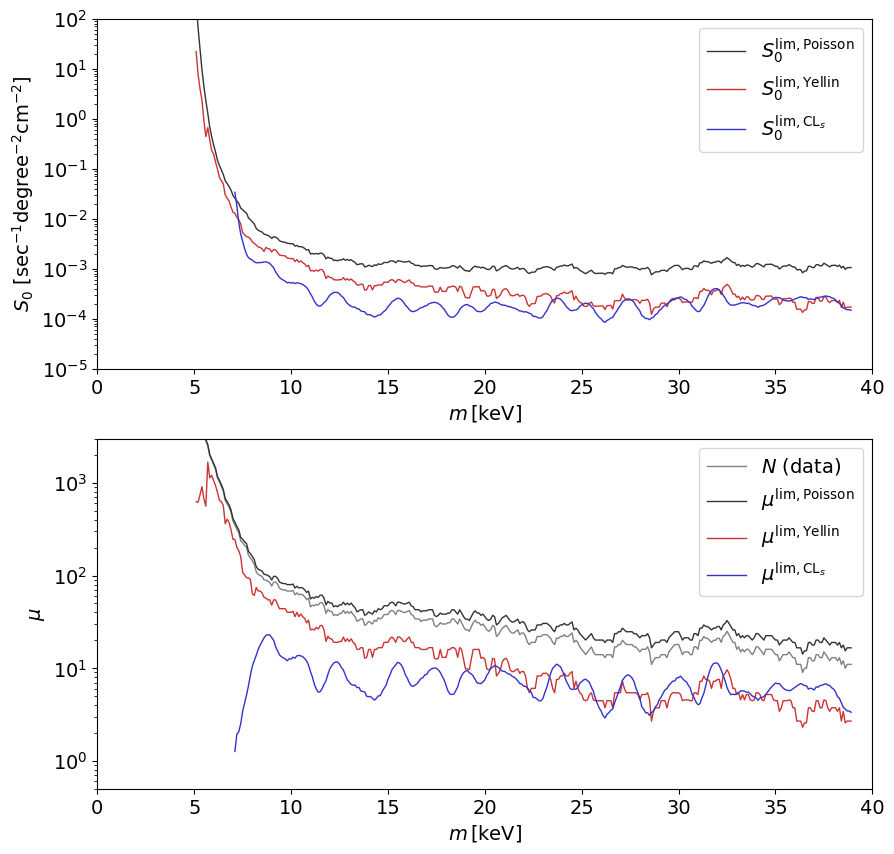

In [16]:
fig_flux_lim,ax = plt.subplots(2,1,figsize=(10,10))
## poisson
df_plot = df_results[df_results['flag_poisson']==True].sort_values(by=['m'])
ax[0].plot(df_plot['m'],df_plot['S_0_lim_poisson'],color=(0.2,0.2,0.2),lw=1,label=r'$S_0^\mathrm{lim,Poisson}$');
ax[1].plot(df_plot['m'],df_plot['N_data'],color=(0.5,0.5,0.5),lw=1,label=r'$N$ (data)') 
ax[1].plot(df_plot['m'],df_plot['N_sig_lim_poisson'],color=(0.2,0.2,0.2),lw=1,label=r'$\mu^\mathrm{lim,Poisson}$') 
## yellin
df_plot = df_results[df_results['flag_yellin']==True].sort_values(by=['m'])
ax[0].plot(df_plot['m'],df_plot['S_0_lim_yellin'],color=(0.8,0.2,0.2),lw=1,label=r'$S_0^\mathrm{lim,Yellin}$')
ax[1].plot(df_plot['m'],df_plot['N_sig_lim_yellin'],color=(0.8,0.2,0.2),lw=1,label=r'$\mu^\mathrm{lim,Yellin}$')
## LL
ax[0].plot(df_LL['m'],df_LL['S_0_lim_CLs'],color=(0.2,0.2,0.8),lw=1,label=r'$S_0^{\mathrm{lim,CL}_s}$')
ax[1].plot(df_LL['m'],df_LL['N_sig_lim_CLs'],color=(0.2,0.2,0.8),lw=1,label=r'$\mu^{\mathrm{lim,CL}_s}$')

## plot stuff
ax[0].set_xlim(0,40); ax[0].set_ylim(1e-5,1e2);
ax[0].set_xscale('linear'); ax[0].set_yscale('log'); ax[0].set_xlabel(r'$m \, [\mathrm{keV}]$'); 
ax[0].set_ylabel(r'$S_0~\mathrm{[sec^{-1} degree^{-2} cm^{-2}]}$'); 
ax[1].set_xlim(0,40); ax[1].set_ylim(0.5,3e3); 
ax[1].set_xscale('linear'); ax[1].set_yscale('log'); ax[1].set_xlabel(r'$m \, [\mathrm{keV}]$'); 
ax[1].set_ylabel(r'$\mu$'); 
ax[0].legend(loc='upper right'); ax[1].legend(loc='upper right');

In [17]:
fig_flux_lim.savefig(dir_fig+'flux_lim.pdf',bbox_inches='tight',pad_inches=0.02);

In [21]:
df_LL

,m,S_0_fit,S_0_lim_unconstrained,S_0_lim_CLs,N_sig_lim_CLs
0,7.1,0.001560,0.026045,0.033757,1.262952
1,7.2,0.003323,0.015713,0.018186,1.935780
2,7.3,0.001325,0.007051,0.008300,2.059812
3,7.4,0.001162,0.004420,0.004934,2.520146
4,7.5,0.001085,0.003259,0.003504,3.431976
...,...,...,...,...,...
314,38.5,0.000004,0.000124,0.000165,3.790864
315,38.6,-0.000005,0.000108,0.000158,3.617734
316,38.7,-0.000012,0.000099,0.000151,3.456259
317,38.8,-0.000018,0.000093,0.000152,3.450366


In [25]:
df_plot_poisson[df_plot_poisson['m']>=7.05]

,i_p,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin,flag_poisson,flag_yellin
99686,294,7.1,2.980128,0.069131,14616.700890,351,376.240683,0.025740,98.946401,0.006769,True,False
99687,294,7.2,2.980128,0.069131,15043.681060,315,338.926324,0.022529,81.180178,0.005396,True,False
99688,294,7.3,2.980128,0.069131,15456.236991,289,312.021803,0.020187,71.145920,0.004603,True,False
99689,294,7.4,2.980128,0.069131,15846.633908,237,257.955098,0.016278,60.995810,0.003849,True,False
99690,294,7.5,2.980128,0.069131,16294.368671,226,246.481267,0.015127,60.995810,0.003743,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
104407,307,38.5,2.980303,0.069480,15934.221817,12,17.780030,0.001116,3.421764,0.000215,True,True
104408,307,38.6,2.980303,0.069480,15850.650423,10,15.406070,0.000972,2.570988,0.000162,True,True
104409,307,38.7,2.980303,0.069480,15821.291183,11,16.596335,0.001049,2.686581,0.000170,True,True
104410,307,38.8,2.980303,0.069480,15767.069546,11,16.596335,0.001053,2.686581,0.000170,True,True


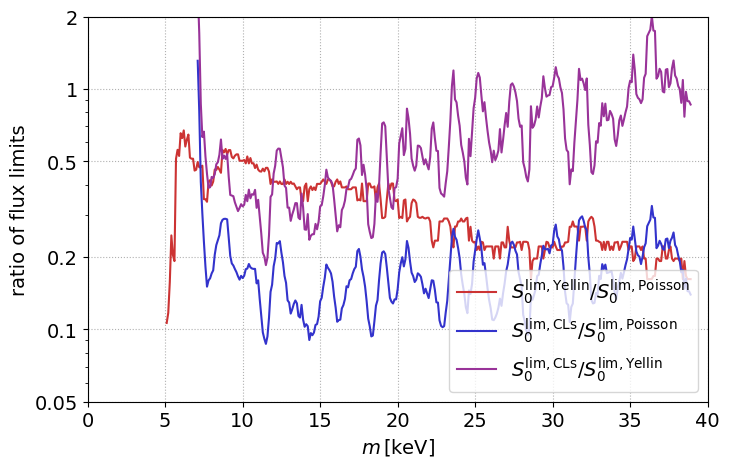

In [30]:
fig_flux_lim_ratio,ax = plt.subplots(1,1,figsize=(8,5))
df_plot_poisson = df_results[df_results['flag_poisson']==True].sort_values(by=['m'])
df_plot_yellin = df_results[df_results['flag_yellin']==True].sort_values(by=['m'])
ax.plot(df_plot_poisson['m'],df_plot_yellin['S_0_lim_yellin'].to_numpy()/df_plot_poisson['S_0_lim_poisson'].to_numpy(),
        color=(0.8,0.2,0.2),
        label=r'$S_0^\mathrm{lim,Yellin}/S_0^\mathrm{lim,Poisson}$')
ax.plot(df_plot_poisson[df_plot_poisson['m']>=7.05]['m'],df_LL[df_LL['m']>=7.05]['S_0_lim_CLs'].to_numpy()/df_plot_poisson[df_plot_poisson['m']>=7.05]['S_0_lim_poisson'].to_numpy(),
        color=(0.2,0.2,0.8),
        label=r'$S_0^\mathrm{lim,CLs}/S_0^\mathrm{lim,Poisson}$')
ax.plot(df_plot_poisson[df_plot_poisson['m']>=7.05]['m'],df_LL[df_LL['m']>=7.05]['S_0_lim_CLs'].to_numpy()/df_plot_yellin[df_plot_yellin['m']>=7.05]['S_0_lim_yellin'].to_numpy(),
        color=(0.6,0.2,0.6),
        label=r'$S_0^\mathrm{lim,CLs}/S_0^\mathrm{lim,Yellin}$')
ax.set_xscale('linear'); ax.set_yscale('log'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'ratio of flux limits'); 
ax.legend(loc='lower right');
ax.set_xlim(0,40); ax.set_ylim(5e-2,2);
ax.set_yticks([5e-2,1e-1,2e-1,5e-1,1,2])
ax.set_yticklabels(['0.05','0.1','0.2','0.5','1','2']);
ax.grid(ls='dotted');

In [31]:
fig_flux_lim_ratio.savefig(dir_fig+'flux_lim_ratio.pdf',bbox_inches='tight',pad_inches=0.02);

# Stellar cooling constraints

In [32]:
def lim_extrapolate(m,T):
    s = m/T;
    def integrand(x):
        if x < 100:
            return x**2 * (x**2 - s**2)**(1/2) / (np.exp(x)-1)
        else:
            return 0
    
    integral = quad(integrand,s,np.max([1e3,1e3*s]))[0]
    prefac = (np.pi**4/15)**-1
    return np.max([1e-100,np.sqrt(prefac * integral)])

In [33]:
def gaee_lim_WD(m,T=10**7 * Kelvin):
    lim_0 = 3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [34]:
def gaee_lim_RG(m,T=10**8 * Kelvin):
    lim_0 = 4.3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [35]:
def gagg_lim_HB(m,T=10**8 * Kelvin):
    lim_0 = 6.6 * 10**-11 * GeV**-1
    return lim_0 / lim_extrapolate(m,T)

# Figures

## Signal production

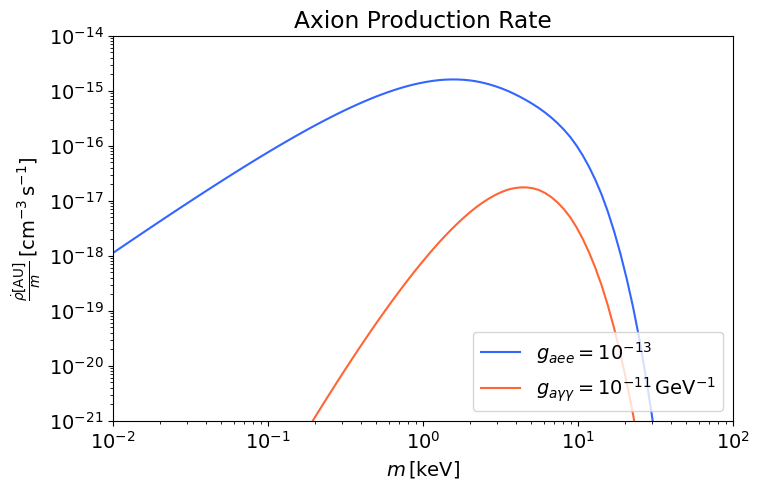

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 1e-13, 0)/(CentiMeter**-3 * Second**-1),
        color = (0.2,0.4,1), label=r'$g_{aee} = 10^{-13}$');
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 0, 1e-11*GeV**-1)/(CentiMeter**-3 * Second**-1),
        color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.01,100);
ax.set_ylim(1e-21,1e-14);
ax.set_ylabel(r'$\frac{\dot{\rho}[\mathrm{AU}]}{m} \, [\mathrm{cm^{-3} \, s^{-1}}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion Production Rate'); ax.legend();

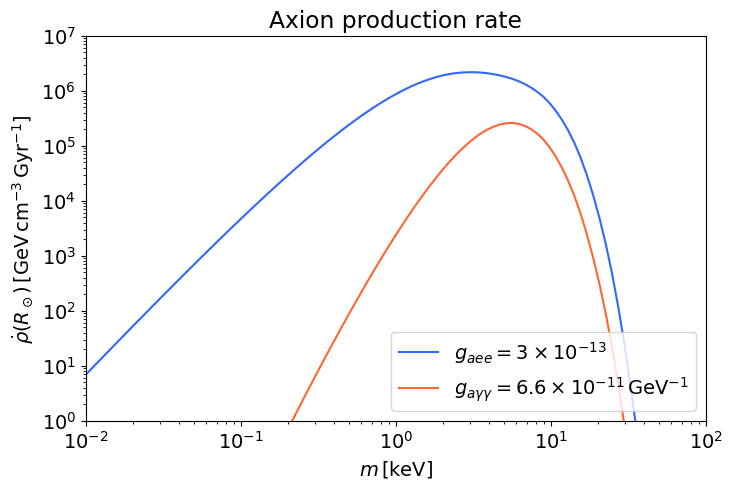

In [37]:
vec_rho_dot_e = (AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 3e-13, 0)
vec_rho_dot_g = (AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 0, 6.6e-11*GeV**-1)

fig_rho_dot, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m,vec_rho_dot_e/(GeV * CentiMeter**-3 * 10**-9 * Year**-1),
        color = (0.2,0.4,1), label=r'$g_{aee} = 3 \times 10^{-13}$');
ax.plot(list_m,vec_rho_dot_g/(GeV * CentiMeter**-3 * 10**-9 * Year**-1), 
        color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 6.6 \times 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.01,100);
ax.set_ylim(1e0,1e7);
ax.set_ylabel(r'$\dot{\rho}(R_\odot) \, [\mathrm{GeV \, cm^{-3} \, Gyr^{-1}}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion production rate'); ax.legend();

In [38]:
fig_rho_dot.savefig(dir_fig+'rho_dot.pdf',bbox_inches='tight',pad_inches=0.02);

## Absorption time

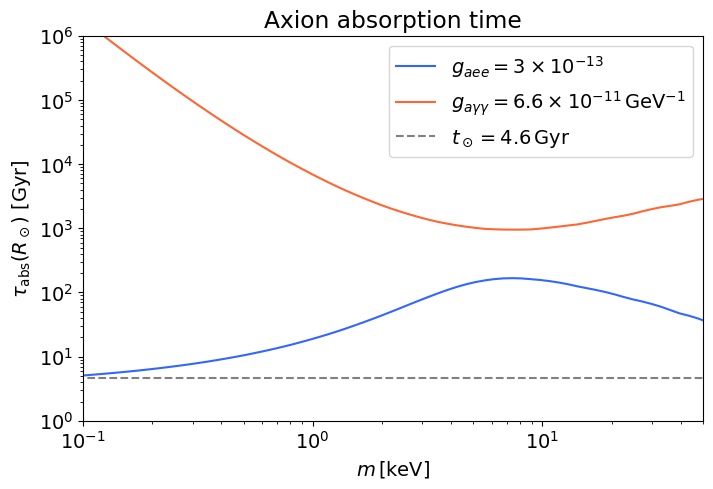

In [39]:
vec_rho_dot_e = (AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 3e-13, 0)
vec_rho_dot_g = (AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 0, 6.6e-11*GeV**-1)

T_sun = 1.3*keV
t_sun = 4.6e9 * Year;

v_esc_sun = np.sqrt(2 * GN * MSolar / RSolar)
vec_tau_abs_e = vec_rho_dot_e**-1 * (list_m * keV)**4 * (np.exp(list_m*keV/(T_sun))-1)**-1 * v_esc_sun**3 / (6*np.pi**2)
vec_tau_abs_g = vec_rho_dot_g**-1 * (list_m * keV)**4 * (np.exp(list_m*keV/(T_sun))-1)**-1 * v_esc_sun**3 / (6*np.pi**2)

fig_tau_abs, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m, vec_tau_abs_e / (1e9 * Year),
        color = (0.2,0.4,1), label=r'$g_{aee} = 3 \times 10^{-13}$');
ax.plot(list_m, vec_tau_abs_g / (1e9 * Year), 
        color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 6.6 \times 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.plot(list_m, np.asarray(len(list_m) * [t_sun]) / (1e9 * Year),
        color = (0.5,0.5,0.5), ls='dashed', label=r'$t_\odot = 4.6\,\mathrm{Gyr}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.1,50);
ax.set_ylim(1e0,1e6);
ax.set_ylabel(r'$\tau_\mathrm{abs}(R_\odot)~[\mathrm{Gyr}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion absorption time'); ax.legend();

In [40]:
fig_tau_abs.savefig(dir_fig+'tau_abs.pdf',bbox_inches='tight',pad_inches=0.02);

## Limit contours at fixed mass

In [44]:
list_m = keV * np.asarray([6., 8., 10., 15., 20., 30.])
list_gaee = np.logspace(-16,-11,np.int(2e2))
list_gagg = GeV**-1 * np.logspace(-15,-8,np.int(3e2))
arr_S0_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_S0_signal[i_m,i_e,i_g] = S0_signal(m,gagg,gaee) * Second *  CentiMeter**2 * degree**2

100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


In [61]:
arr_S0_limit = np.nan * np.ones((len(list_m),3))
for i,m in enumerate(list_m/keV):
    arr_S0_limit[i,0] = df_plot_poisson[np.abs(df_plot_poisson['m']-m)<0.01]['S_0_lim_poisson'].to_numpy()
    arr_S0_limit[i,1] = df_plot_yellin[np.abs(df_plot_yellin['m']-m)<0.01]['S_0_lim_yellin'].to_numpy()
    try:
        arr_S0_limit[i,2] = df_LL[np.abs(df_LL['m']-m)<0.01]['S_0_lim_CLs'].to_numpy()
    except ValueError:
        arr_S0_limit[i,2] = 1e10

In [62]:
arr_S0_limit

array([[2.99845643e-01, 1.96488451e-01, 1.00000000e+10],
       [8.67051434e-03, 3.44082673e-03, 1.48203258e-03],
       [3.15493595e-03, 1.58730917e-03, 5.15904508e-04],
       [1.33064187e-03, 5.36332912e-04, 1.74224443e-04],
       [1.02713136e-03, 3.56541771e-04, 1.51013475e-04],
       [1.16599154e-03, 2.55788764e-04, 2.62840186e-04]])

In [63]:
arr_ratio_lim = np.asarray([np.transpose(np.transpose(arr_S0_signal)/arr_S0_limit[:,i]) for i in range(3)])

In [64]:
arr_ratio_lim.shape

(3, 6, 200, 300)

In [65]:
arr_ratio_prod = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_ratio_prod[i_m,i_e,i_g] = fn_rho_dot_over_m(m,0,gagg)/fn_rho_dot_over_m(m,gaee,0)

100%|██████████| 6/6 [00:29<00:00,  4.86s/it]


In [66]:
arr_ratio_prod.shape

(6, 200, 300)

In [67]:
list_f = GeV * 10**np.arange(13.,5.,-1.0)
list_f_label = ['$10^{13}\,\mathrm{GeV}$','$10^{12}\,\mathrm{GeV}$','$10^{11}\,\mathrm{GeV}$','$10^{10}\,\mathrm{GeV}$','$10^{9}\,\mathrm{GeV}$',
                '$10^{8}\,\mathrm{GeV}$', '$10^{7}\,\mathrm{GeV}$', '$10^{6}\,\mathrm{GeV}$']
list_gagg_uni = (AlphaEM/(2*np.pi)) / list_f
list_gaee_uni = MElectron / list_f
list_gaee_sup = (AlphaEM/(2*np.pi)) * MElectron / list_f

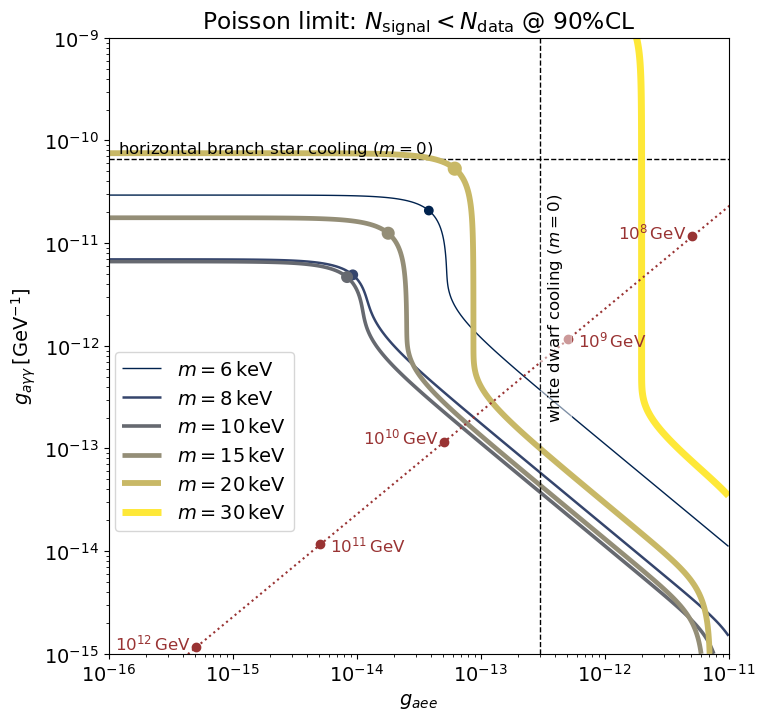

In [68]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim0, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_uni,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[0,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f == 1) or (i_f==3) or (i_f == 5):
        ax.text(list_gaee_uni[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f == 2) or (i_f==4):
        ax.text(list_gaee_uni[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [69]:
fig_lim0.savefig(dir_fig+'lim_m_contours_poisson.pdf',bbox_inches='tight',pad_inches=0.02);

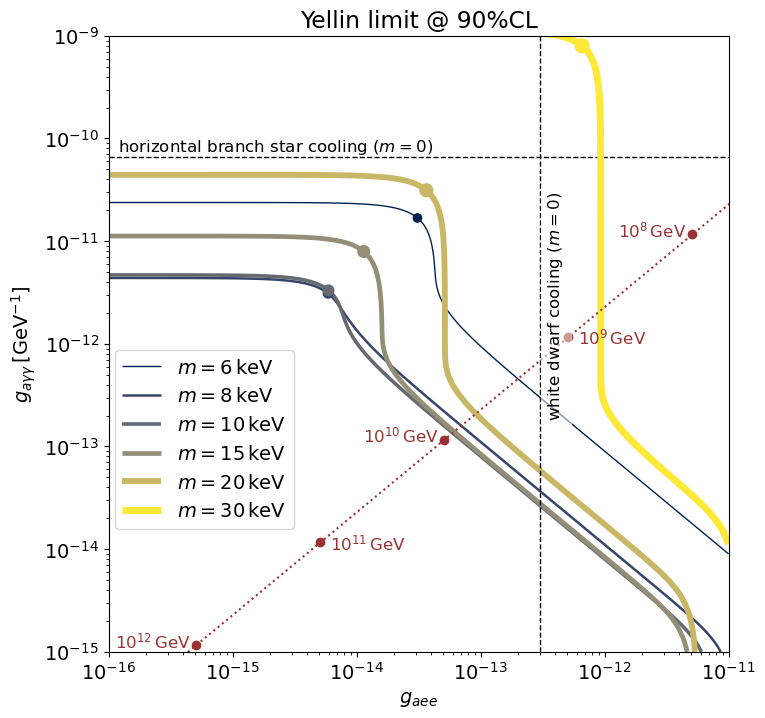

In [76]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim1, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_uni,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[1,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title('Yellin limit @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f == 1) or (i_f==3) or (i_f == 5):
        ax.text(list_gaee_uni[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f == 2) or (i_f==4):
        ax.text(list_gaee_uni[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [71]:
fig_lim1.savefig(dir_fig+'lim_m_contours_yellin.pdf',bbox_inches='tight',pad_inches=0.02);

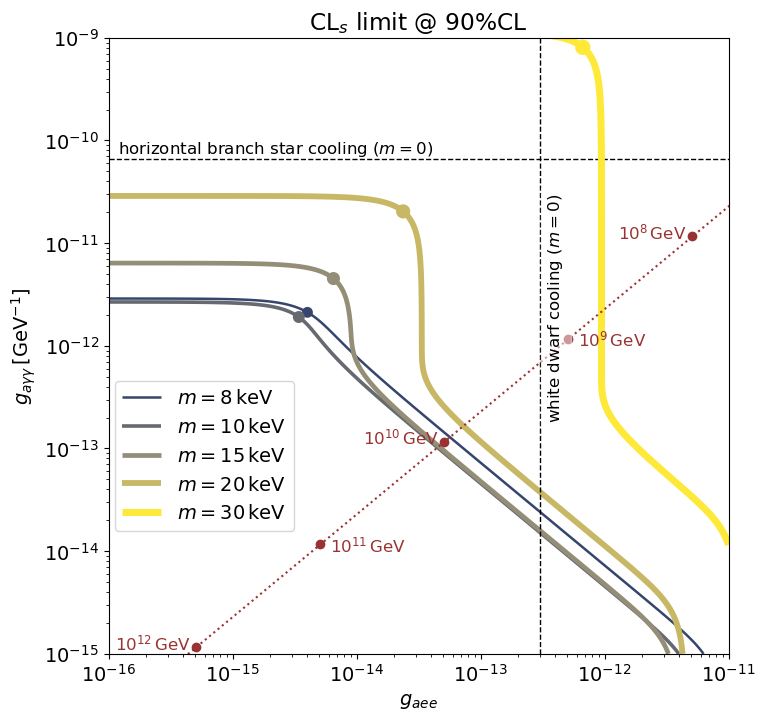

In [88]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim2, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_uni,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    if i_m==0:
        continue
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[2,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    ax.collections[2*i_m-1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title(r'$\mathrm{CL}_s$ limit @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f == 1) or (i_f==3) or (i_f == 5):
        ax.text(list_gaee_uni[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f == 2) or (i_f==4):
        ax.text(list_gaee_uni[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [89]:
fig_lim2.savefig(dir_fig+'lim_m_contours_LL.pdf',bbox_inches='tight',pad_inches=0.02);

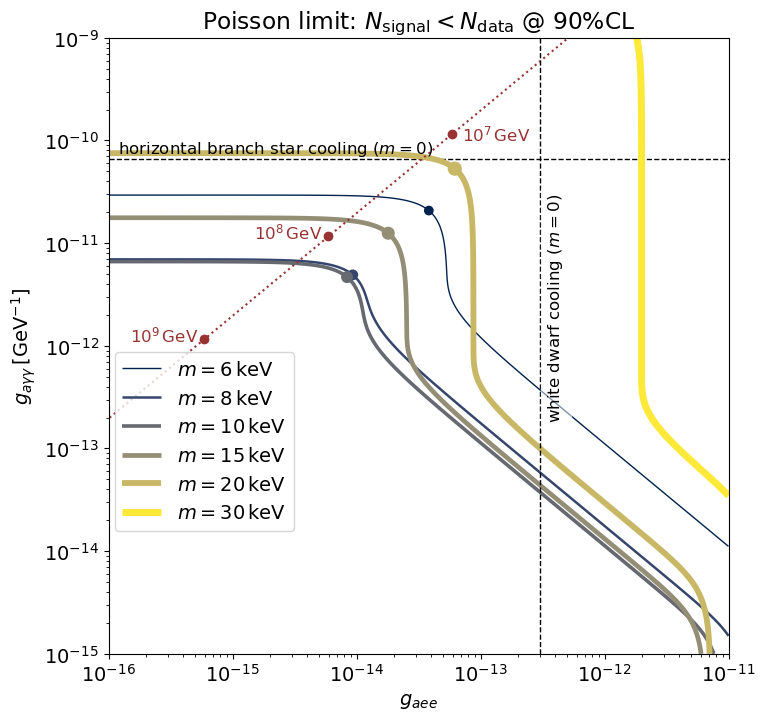

In [90]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim0_2, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_sup,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[0,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f==4) or (i_f == 5):
        ax.text(list_gaee_sup[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f==6):
        ax.text(list_gaee_sup[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [91]:
fig_lim0_2.savefig(dir_fig+'lim_m_contours_poisson_electrophobic.pdf',bbox_inches='tight',pad_inches=0.02);

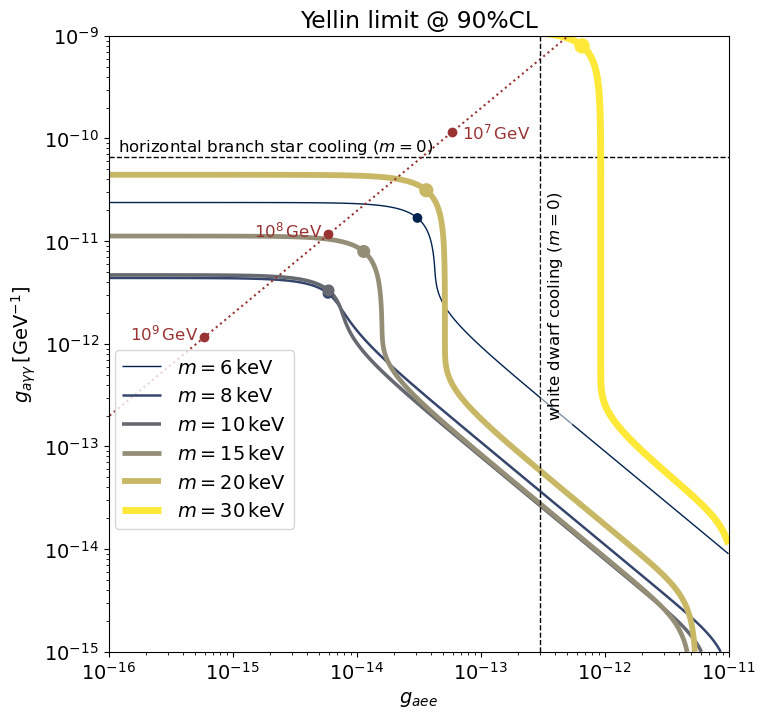

In [92]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim1_2, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_sup,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[0,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title('Yellin limit @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f==4) or (i_f == 5):
        ax.text(list_gaee_sup[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f==6):
        ax.text(list_gaee_sup[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [93]:
fig_lim1_2.savefig(dir_fig+'lim_m_contours_yellin_electrophobic.pdf',bbox_inches='tight',pad_inches=0.02);

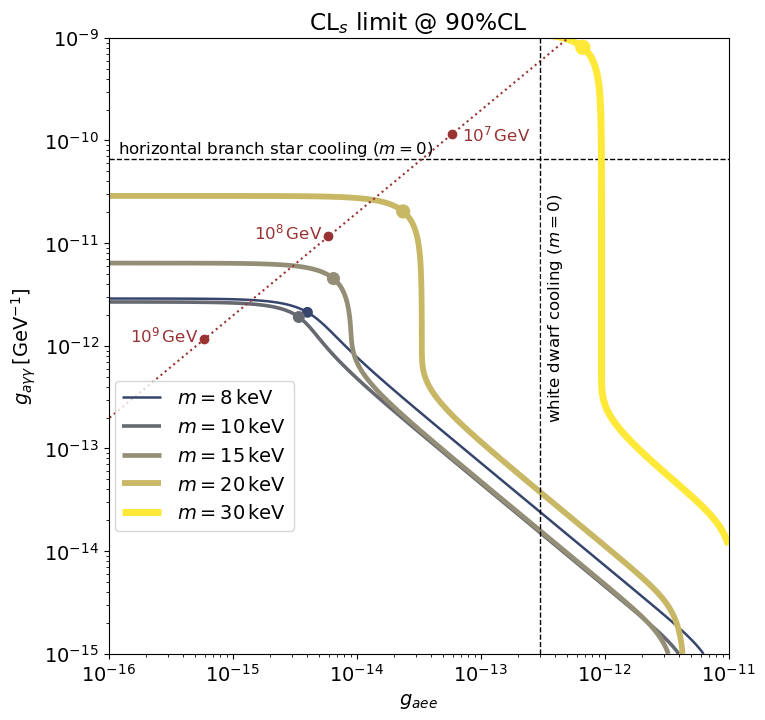

In [94]:
cmap = mp.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$',
          '$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$','$m = 30 \, \mathrm{keV}$']
fig_lim2_2, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(list_gaee_sup,list_gagg_uni,color=(0.6,0.2,0.2),ls='dotted',marker='.',markersize=12)
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    if i_m==0:
        continue
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_lim[2,i_m])),levels=[np.log10(1)],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_ratio_prod[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    ax.collections[2*i_m-1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc=(0.01,0.2));
ax.set_title(r'$\mathrm{CL}_s$ limit @ 90%CL');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));
for i_f,f_label in enumerate(list_f_label):
    if (i_f==4) or (i_f == 5):
        ax.text(list_gaee_sup[i_f]*(0.9),list_gagg_uni[i_f]*(0.95),f_label,ha='right',fontsize=12,color=(0.6,0.2,0.2))
    elif (i_f==6):
        ax.text(list_gaee_sup[i_f]*(1.2),list_gagg_uni[i_f]*(0.85),f_label,fontsize=12,color=(0.6,0.2,0.2))

In [95]:
fig_lim2_2.savefig(dir_fig+'lim_m_contours_LL_electrophobic.pdf',bbox_inches='tight',pad_inches=0.02);

## Photon Coupling Limit

In [145]:
list_m = keV * df_plot_poisson['m'].to_numpy()
list_m = np.concatenate([[list_m[0]-0.2*keV,list_m[0]-0.1*keV],list_m])
list_gaee = np.asarray([0,1e-14,1e-13,1e-12])
list_gagg = GeV**-1 * np.logspace(-15,-9,np.int(3e2))
arr_S0_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_S0_signal[i_m,i_e,i_g] = S0_signal(m,gagg,gaee) * Second *  CentiMeter**2 * degree**2 + 1e-100

100%|██████████| 341/341 [00:21<00:00, 16.16it/s]


In [146]:
arr_S0_limit = np.nan * np.ones((len(list_m),3))
for i,m in enumerate(list_m/keV):
    try:
        arr_S0_limit[i,0] = df_plot_poisson[np.abs(df_plot_poisson['m']-m)<0.01]['S_0_lim_poisson'].to_numpy()
        arr_S0_limit[i,1] = df_plot_yellin[np.abs(df_plot_yellin['m']-m)<0.01]['S_0_lim_yellin'].to_numpy()
    except ValueError:
        arr_S0_limit[i,0] = 1e10
        arr_S0_limit[i,1] = 1e10
    try:
        arr_S0_limit[i,2] = df_LL[np.abs(df_LL['m']-m)<0.01]['S_0_lim_CLs'].to_numpy()
    except ValueError:
        arr_S0_limit[i,2] = 1e10

In [147]:
arr_ratio_lim = np.asarray([np.transpose(np.transpose(arr_S0_signal)/arr_S0_limit[:,i]) for i in range(3)])

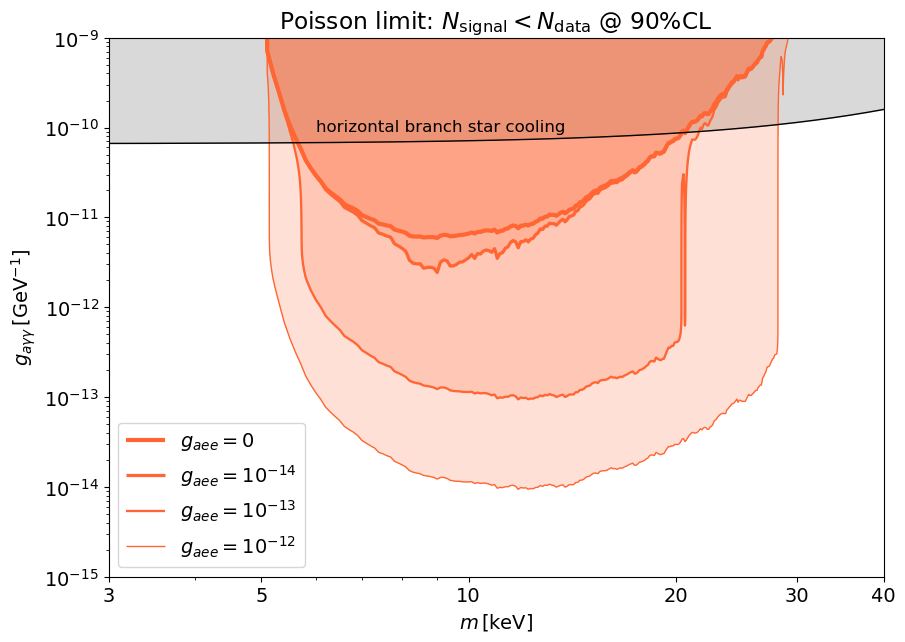

In [150]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot0, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[0,:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[0,:,i_e,:])),levels=[0,+100],colors=[(1.,0.4,0.2,0.2)])
ax.set_xlim(3,40); ax.set_ylim(list_gagg[0],list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [151]:
fig_lim_phot0.savefig(dir_fig+'lim_photon_poisson.pdf',bbox_inches='tight',pad_inches=0.02);

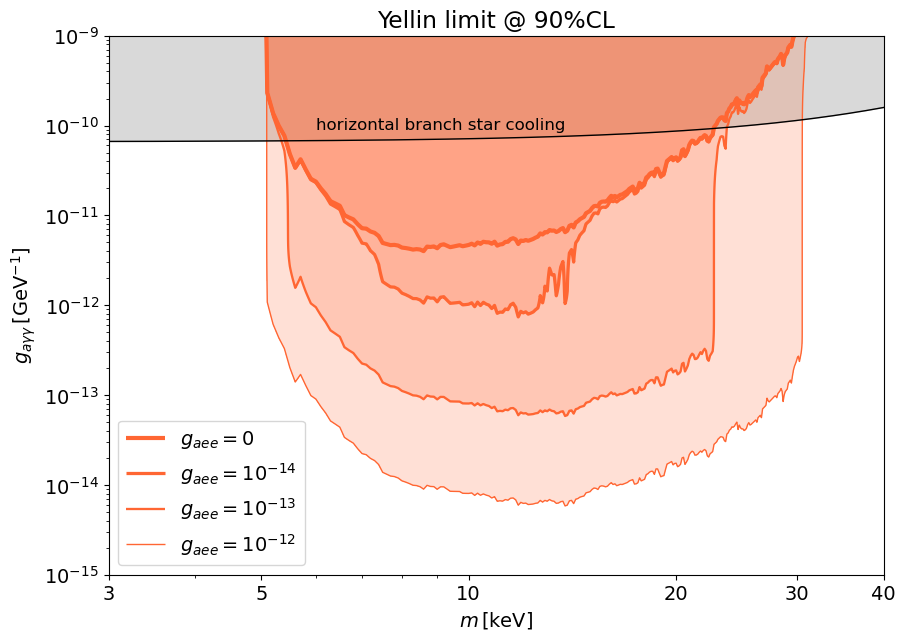

In [152]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot1, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[1,:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[1,:,i_e,:])),levels=[0,+100],colors=[(1.,0.4,0.2,0.2)])
ax.set_xlim(3,40); ax.set_ylim(list_gagg[0],list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Yellin limit @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [153]:
fig_lim_phot1.savefig(dir_fig+'lim_photon_yellin.pdf',bbox_inches='tight',pad_inches=0.02);

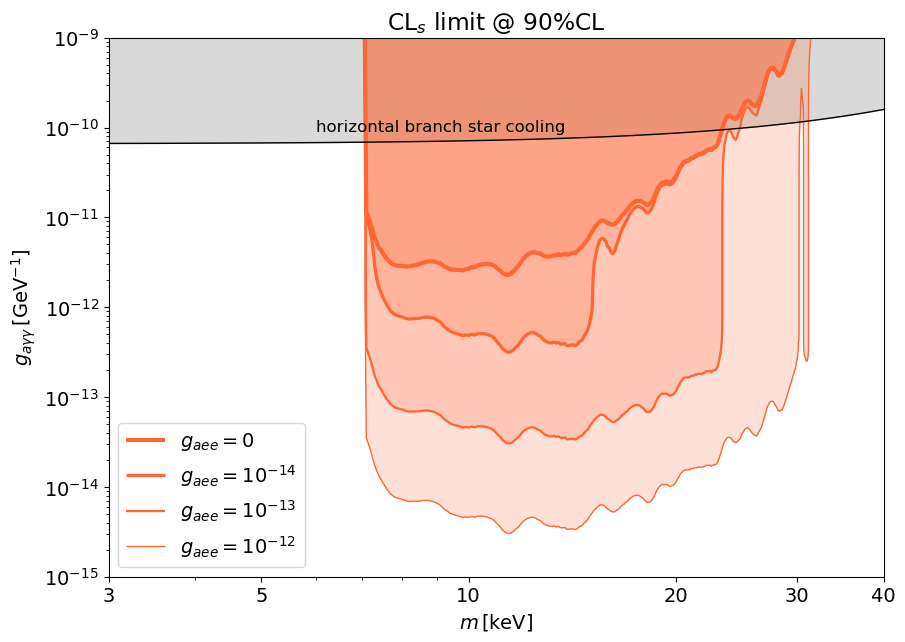

In [154]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot2, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[2,:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[2,:,i_e,:])),levels=[0,+100],colors=[(1.,0.4,0.2,0.2)])
ax.set_xlim(3,40); ax.set_ylim(list_gagg[0],list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title(r'$\mathrm{CL}_s$ limit @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [155]:
fig_lim_phot2.savefig(dir_fig+'lim_photon_LL.pdf',bbox_inches='tight',pad_inches=0.02);

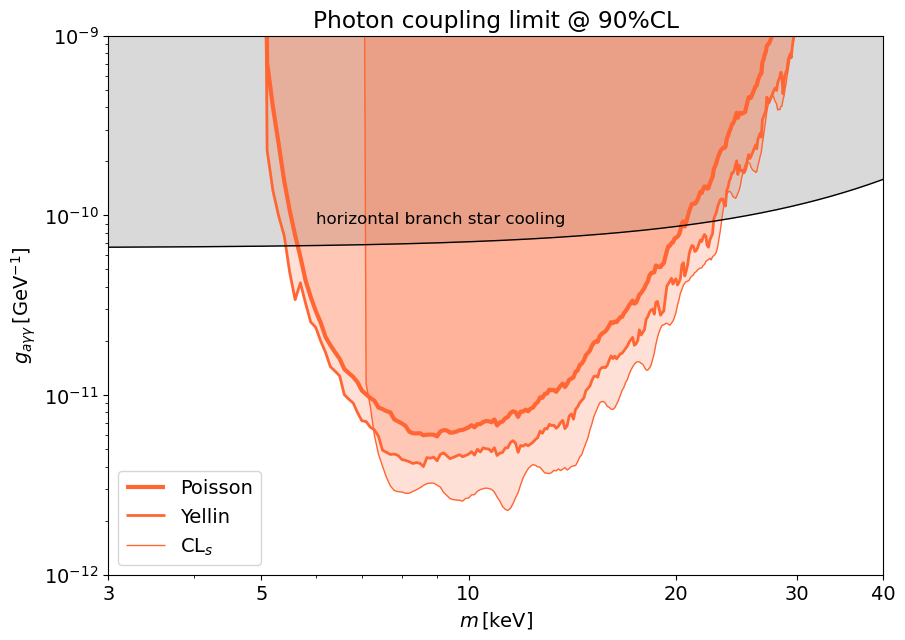

In [156]:
list_lw = np.linspace(3,1,3)
fig_lim_phot_all, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['Poisson','Yellin','$\mathrm{CL}_s$']
for i in range(3):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[i,:,0,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i])
    ax.collections[i+1].set_label(labels[i])
for i in range(3):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_ratio_lim[i,:,0,:])),levels=[0,+100],colors=[(1.,0.4,0.2,0.2)])

ax.set_xlim(3,40); ax.set_ylim(1e-12,list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title(r'Photon coupling limit @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [157]:
fig_lim_phot_all.savefig(dir_fig+'lim_photon_all.pdf',bbox_inches='tight',pad_inches=0.02);

## Electron Coupling Limit

In [158]:
list_m = keV * df_plot_poisson['m'].to_numpy()
list_m = np.concatenate([[list_m[0]-0.2*keV,list_m[0]-0.1*keV],list_m])
list_gaee = np.logspace(-16,-10,np.int(2e2))
list_gagg = GeV**-1 * np.asarray([0,1e-14,1e-13,1e-12,1e-11,1e-10])
arr_S0_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_S0_signal[i_m,i_e,i_g] = S0_signal(m,gagg,gaee) * Second *  CentiMeter**2 * degree**2 + 1e-100

100%|██████████| 341/341 [00:21<00:00, 15.80it/s]


In [159]:
arr_S0_limit = np.nan * np.ones((len(list_m),3))
for i,m in enumerate(list_m/keV):
    try:
        arr_S0_limit[i,0] = df_plot_poisson[np.abs(df_plot_poisson['m']-m)<0.01]['S_0_lim_poisson'].to_numpy()
        arr_S0_limit[i,1] = df_plot_yellin[np.abs(df_plot_yellin['m']-m)<0.01]['S_0_lim_yellin'].to_numpy()
    except ValueError:
        arr_S0_limit[i,0] = 1e10
        arr_S0_limit[i,1] = 1e10
    try:
        arr_S0_limit[i,2] = df_LL[np.abs(df_LL['m']-m)<0.01]['S_0_lim_CLs'].to_numpy()
    except ValueError:
        arr_S0_limit[i,2] = 1e10

In [160]:
arr_ratio_lim = np.asarray([np.transpose(np.transpose(arr_S0_signal)/arr_S0_limit[:,i]) for i in range(3)])

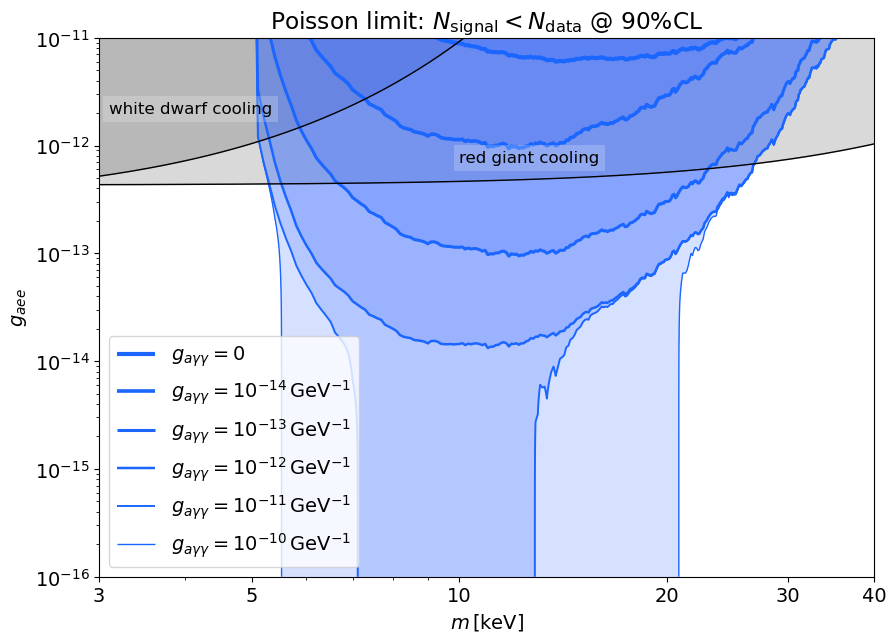

In [161]:
list_lw = np.linspace(3,1,len(list_gagg))
fig_lim_electron0, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(list_gagg):
    ax.contour(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[0,:,:,i_g])),levels=[0],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(list_gagg):
    ax.contourf(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[0,:,:,i_g])),levels=[0,+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(3,40); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(3.1,2e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

In [162]:
fig_lim_electron0.savefig(dir_fig+'lim_electron_poisson.pdf',bbox_inches='tight',pad_inches=0.02);

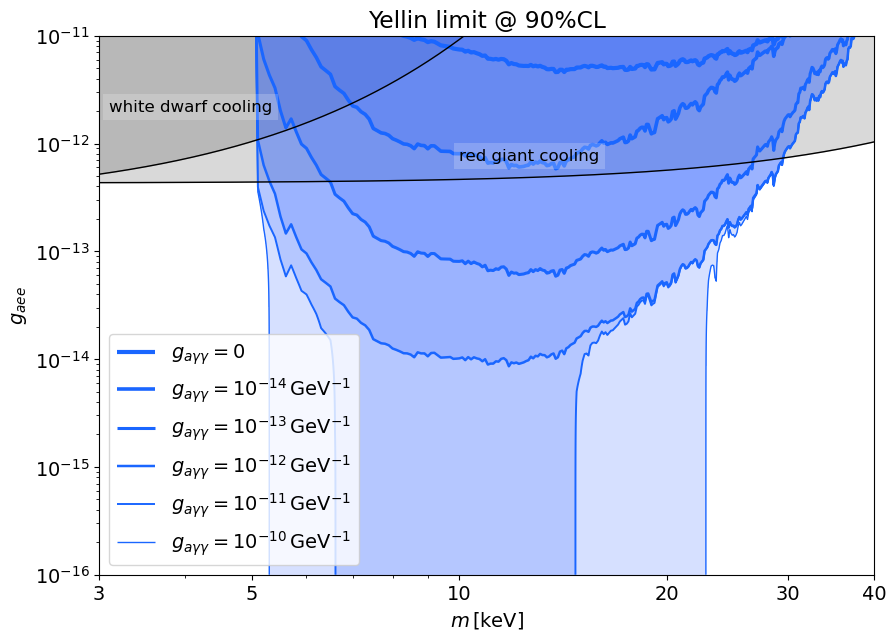

In [163]:
list_lw = np.linspace(3,1,len(list_gagg))
fig_lim_electron1, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(list_gagg):
    ax.contour(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[1,:,:,i_g])),levels=[0],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(list_gagg):
    ax.contourf(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[1,:,:,i_g])),levels=[0,+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(3,40); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Yellin limit @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(3.1,2e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

In [164]:
fig_lim_electron1.savefig(dir_fig+'lim_electron_yellin.pdf',bbox_inches='tight',pad_inches=0.02);

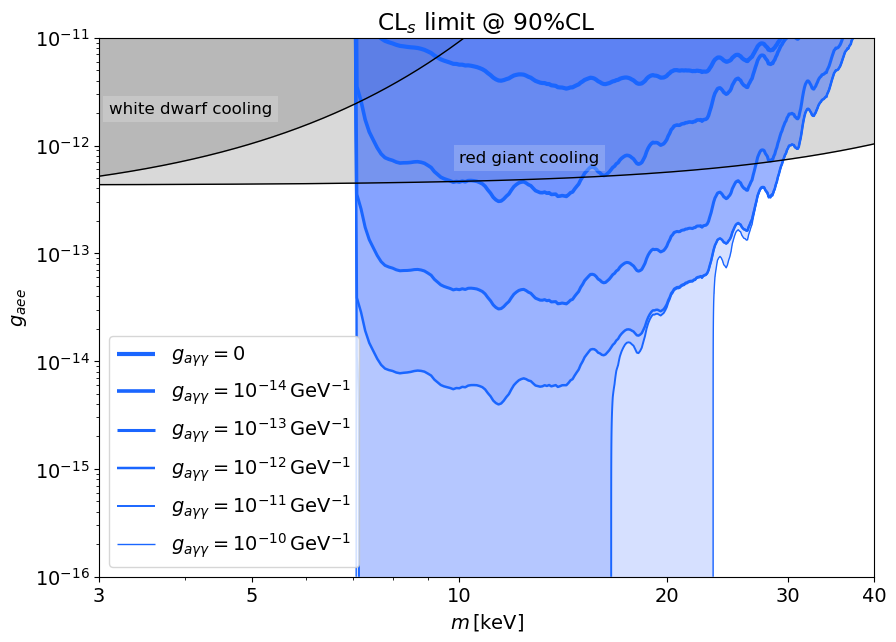

In [165]:
list_lw = np.linspace(3,1,len(list_gagg))
fig_lim_electron2, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(list_gagg):
    ax.contour(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[2,:,:,i_g])),levels=[0],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(list_gagg):
    ax.contourf(list_m/keV,list_gaee,np.log10(np.transpose(arr_ratio_lim[2,:,:,i_g])),levels=[0,+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(3,40); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title(r'$\mathrm{CL}_s$ limit @ 90%CL');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(3.1,2e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

In [166]:
fig_lim_electron2.savefig(dir_fig+'lim_electron_LL.pdf',bbox_inches='tight',pad_inches=0.02);

## Universal Limit

In [167]:
list_m = keV * df_plot_poisson['m'].to_numpy()
list_m = np.concatenate([[list_m[0]-0.2*keV,list_m[0]-0.1*keV],list_m])
list_f = GeV * np.logspace(13,7,np.int(5e2))
arr_S0_signal = np.zeros((len(list_m),len(list_f)))

for i_m, m in enumerate(tqdm(list_m)):
    for i_f, f in enumerate(list_f):
        gagg = (AlphaEM/(2*np.pi)) / f
        gaee = MElectron / f
        arr_S0_signal[i_m,i_f] = S0_signal(m,gagg,gaee) * Second *  CentiMeter**2 * degree**2 + 1e-100

100%|██████████| 341/341 [00:09<00:00, 37.70it/s]


In [168]:
arr_S0_limit = np.nan * np.ones((len(list_m),3))
for i,m in enumerate(list_m/keV):
    try:
        arr_S0_limit[i,0] = df_plot_poisson[np.abs(df_plot_poisson['m']-m)<0.01]['S_0_lim_poisson'].to_numpy()
        arr_S0_limit[i,1] = df_plot_yellin[np.abs(df_plot_yellin['m']-m)<0.01]['S_0_lim_yellin'].to_numpy()
    except ValueError:
        arr_S0_limit[i,0] = 1e10
        arr_S0_limit[i,1] = 1e10
    try:
        arr_S0_limit[i,2] = df_LL[np.abs(df_LL['m']-m)<0.01]['S_0_lim_CLs'].to_numpy()
    except ValueError:
        arr_S0_limit[i,2] = 1e10

In [169]:
arr_ratio_lim = np.asarray([np.transpose(np.transpose(arr_S0_signal)/arr_S0_limit[:,i]) for i in range(3)])

In [170]:
arr_ratio_lim.shape

(3, 341, 500)

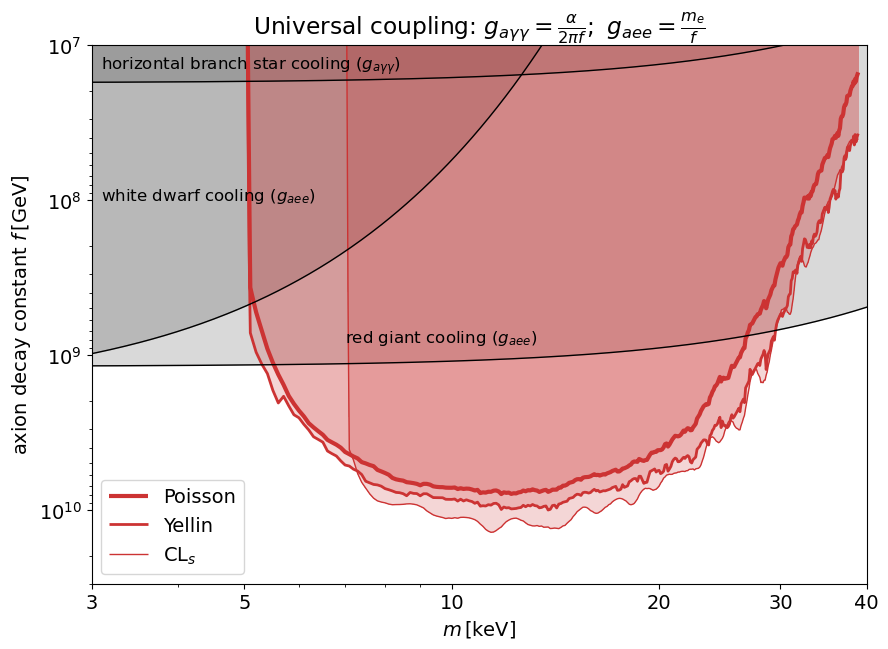

In [171]:
fig_lim_uni, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(vec_m/keV, np.asarray([gagg_lim_HB(m) / (AlphaEM/(2*np.pi)) for m in vec_m])**-1,ls='solid',color='black',lw=1);
ax.plot(vec_m/keV,np.asarray([gaee_lim_WD(m) / (MElectron) for m in vec_m])**-1,ls='solid',color='black',lw=1)
ax.plot(vec_m/keV,np.asarray([gaee_lim_RG(m) / (MElectron) for m in vec_m])**-1,ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,np.asarray([gagg_lim_HB(m) / (AlphaEM/(2*np.pi)) for m in vec_m])**-1,1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,np.asarray([gaee_lim_WD(m) / (MElectron) for m in vec_m])**-1,1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,np.asarray([gaee_lim_RG(m) / (MElectron) for m in vec_m])**-1,1,color=(0,0,0,0.15))

ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[0,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=3)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[0,:,:])),levels=[0,+100],colors=[(0.8,0.2,0.2,0.2)])
ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[1,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=2)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[1,:,:])),levels=[0,+100],colors=[(0.8,0.2,0.2,0.2)])
ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[2,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=1)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[2,:,:])),levels=[0,+100],colors=[(0.8,0.2,0.2,0.2)])
labels = ['Poisson', 'Yellin', r'$\mathrm{CL}_s$']
ax.collections[3].set_label(labels[0])
ax.collections[5].set_label(labels[1])
ax.collections[7].set_label(labels[2])

ax.set_xlim(3,40); ax.set_ylim(3e10,1e7);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'axion decay constant $f \, [\mathrm{GeV}]$'); ax.legend(loc='lower left');
ax.set_title(r'Universal coupling: $g_{a\gamma\gamma} = \frac{\alpha}{2\pi f}; ~ g_{aee} = \frac{m_e}{f}$');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(3.1,(6.9e-8)**-1,'horizontal branch star cooling ($g_{a\gamma \gamma}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));
ax.text(3.1,(1e-8)**-1,'white dwarf cooling ($g_{aee}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));
ax.text(7,(1.2e-9)**-1,'red giant cooling ($g_{aee}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [172]:
fig_lim_uni.savefig(dir_fig+'lim_universal.pdf',bbox_inches='tight',pad_inches=0.02);

## Electrophobic Limit

In [173]:
list_m = keV * df_plot_poisson['m'].to_numpy()
list_m = np.concatenate([[list_m[0]-0.2*keV,list_m[0]-0.1*keV],list_m])
list_f = GeV * np.logspace(11,5,np.int(5e2))
arr_S0_signal = np.zeros((len(list_m),len(list_f)))

for i_m, m in enumerate(tqdm(list_m)):
    for i_f, f in enumerate(list_f):
        gagg = (AlphaEM/(2*np.pi)) / f
        gaee = (AlphaEM/(2*np.pi)) * MElectron / f
        arr_S0_signal[i_m,i_f] = S0_signal(m,gagg,gaee) * Second *  CentiMeter**2 * degree**2 + 1e-100

100%|██████████| 341/341 [00:09<00:00, 37.33it/s]


In [174]:
arr_S0_limit = np.nan * np.ones((len(list_m),3))
for i,m in enumerate(list_m/keV):
    try:
        arr_S0_limit[i,0] = df_plot_poisson[np.abs(df_plot_poisson['m']-m)<0.01]['S_0_lim_poisson'].to_numpy()
        arr_S0_limit[i,1] = df_plot_yellin[np.abs(df_plot_yellin['m']-m)<0.01]['S_0_lim_yellin'].to_numpy()
    except ValueError:
        arr_S0_limit[i,0] = 1e10
        arr_S0_limit[i,1] = 1e10
    try:
        arr_S0_limit[i,2] = df_LL[np.abs(df_LL['m']-m)<0.01]['S_0_lim_CLs'].to_numpy()
    except ValueError:
        arr_S0_limit[i,2] = 1e10

In [175]:
arr_ratio_lim = np.asarray([np.transpose(np.transpose(arr_S0_signal)/arr_S0_limit[:,i]) for i in range(3)])

In [176]:
arr_ratio_lim.shape

(3, 341, 500)

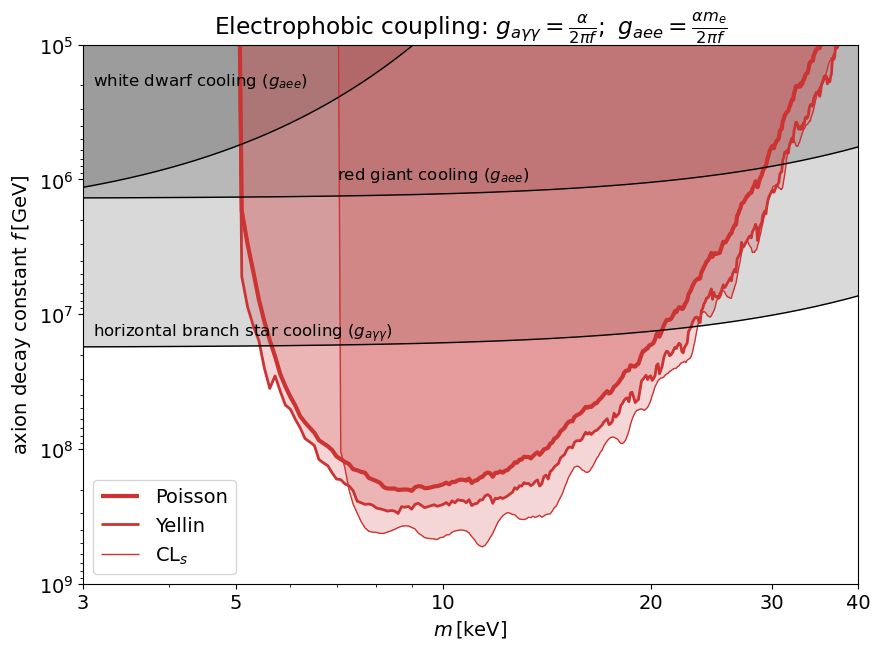

In [177]:
fig_lim_sup, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(vec_m/keV, np.asarray([gagg_lim_HB(m) / (AlphaEM/(2*np.pi)) for m in vec_m])**-1,ls='solid',color='black',lw=1);
ax.plot(vec_m/keV,np.asarray([gaee_lim_WD(m) / ((AlphaEM/(2*np.pi)) * MElectron) for m in vec_m])**-1,ls='solid',color='black',lw=1)
ax.plot(vec_m/keV,np.asarray([gaee_lim_RG(m) / ((AlphaEM/(2*np.pi)) * MElectron) for m in vec_m])**-1,ls='solid',color='black',lw=1)
ax.fill_between(vec_m/keV,np.asarray([gagg_lim_HB(m) / (AlphaEM/(2*np.pi)) for m in vec_m])**-1,1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,np.asarray([gaee_lim_WD(m) / ((AlphaEM/(2*np.pi))*MElectron) for m in vec_m])**-1,1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,np.asarray([gaee_lim_RG(m) / ((AlphaEM/(2*np.pi))*MElectron) for m in vec_m])**-1,1,color=(0,0,0,0.15))

ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[0,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=3)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[0,:,:])),levels=[0,+200],colors=[(0.8,0.2,0.2,0.2)])
ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[1,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=2)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[1,:,:])),levels=[0,+200],colors=[(0.8,0.2,0.2,0.2)])
ax.contour(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[2,:,:])),levels=[0],colors=[(0.8,0.2,0.2)],linewidths=1)
ax.contourf(list_m/keV,list_f,np.log10(np.transpose(arr_ratio_lim[2,:,:])),levels=[0,+200],colors=[(0.8,0.2,0.2,0.2)])
labels = ['Poisson', 'Yellin', r'$\mathrm{CL}_s$']
ax.collections[3].set_label(labels[0])
ax.collections[5].set_label(labels[1])
ax.collections[7].set_label(labels[2])

ax.set_xlim(3,40); ax.set_ylim(1e9,1e5);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'axion decay constant $f \, [\mathrm{GeV}]$'); ax.legend(loc='lower left');
ax.set_title(r'Electrophobic coupling: $g_{a\gamma\gamma} = \frac{\alpha}{2\pi f}; ~ g_{aee} = \frac{\alpha m_e}{2\pi f}$');
ax.set_xticks([3,5,10,20,30,40],minor=False)
ax.set_xticklabels([3,5,10,20,30,40])
ax.text(3.1,(6.9e-8)**-1,'horizontal branch star cooling ($g_{a\gamma \gamma}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));
ax.text(3.1,(5e-6)**-1,'white dwarf cooling ($g_{aee}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));
ax.text(7,(1e-6)**-1,'red giant cooling ($g_{aee}$)',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [178]:
fig_lim_sup.savefig(dir_fig+'lim_electrophobic.pdf',bbox_inches='tight',pad_inches=0.02);